In [2]:
# Условие этой лабы очень простое: построить непараметрическую регрессию. 
# Вы можете использовать любые из существующих методов построения непараметрической регрессии, 
# однако Вы должны уметь доступно и с формулками объяснять, что у Вас происходит и как оно считается. 
# Требуется реализовать минимум 2 метода. Также требуется посчитать MSE, а также рисовать всякие графики.

In [101]:
%matplotlib inline
%load_ext autoreload
%autoreload 5
%autosave 15    
import numpy as np
import pandas as pd
import math
import random
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.cross_validation import KFold
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import accuracy_score, f1_score
from scipy.spatial.distance import euclidean, cityblock, cosine, correlation
from IPython.display import display, HTML
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Autosaving every 15 seconds


In [16]:
data = pd.read_table("D:/Users/Daria/Code2/MachineLearning/hw5_non_parametr_regression/non-parametric.csv", sep=";", header=0, names=['id', 'x', 'y'])
points = data[['x', 'y']].as_matrix()

In [106]:
# kernels
square_kernel = lambda u: 15.0 / 16 * (1 - u ** 2) ** 2 * (abs(u) <= 1)
epan_kernel = lambda u: 0.75 * (1 - u ** 2) * (abs(u) <= 1)
gauss_kernel = lambda u: (2 * math.pi) ** (-1.0 / 2)* math.exp(-u ** 2 / 2.0)
triangle_kernel = lambda u: (1 - abs(u)) * (abs(u) <= 1)
rectangle_kernel = lambda u: 1.0 / 2 * (abs(u) <= 1)
LOWESS_kernel = lambda u: (1 - u ** 2) ** 2 * (abs(u) <= 1)
kernels = [square_kernel, epan_kernel, gauss_kernel, triangle_kernel, rectangle_kernel]
kernelStr = dict()
kernelStr[square_kernel] = "square kernel"
kernelStr[epan_kernel] = "epan kernel"
kernelStr[gauss_kernel] = "gauss kernel"
kernelStr[triangle_kernel] = "triangle kernel"
kernelStr[rectangle_kernel] = "rectangle kernel"
metrics = [cityblock, euclidean, cityblock, cosine, correlation]

In [107]:
curKernel = gauss_kernel
dist = euclidean
delta = [1] * len(points)
maxi = int(max([xi for [xi, yi] in points]))
optH = 3
def getOptimalH():    
    h = optH
    mini = sum([(getY(points[i][0], h, i) - points[i][1]) ** 2 for i in range(len(points))])    
    hh = 1.1
    while (hh < 10):
        curM = sum([(getY(points[i][0], hh, i) - points[i][1]) ** 2 for i in range(len(points))])
        print(hh, " ", curM)
        if (curM < mini):
            mini = curM
            h = hh 
        hh += 0.5
    return h
    
def getY(x, curH, exceptPoint=-1):
    a = 0.0
    b = 0.0
    for i in range(len(points)):        
        if (i == exceptPoint):
            continue
        [xi, yi] = points[i]
        wi = curKernel(dist(x, xi) / curH)
        a += yi * wi * delta[i]
        b += wi * delta[i]
    if (b == 0):
        return 0
    return a / b

def LOWESS():
    for k in range(3):
        curY = []        
        for i in range(len(points)):            
            res = getY(points[i][0], optH, i)
            curY.append(res)
        s = np.median([abs(curY[i] - points[i][1]) for i in range(len(points))])
        for i in range(len(points)):
            epsi = abs(curY[i] - points[i][1])
            delta[i] = LOWESS_kernel(epsi / (6.0 * s))  

kernel =  square kernel ; mean squared error =  809.134967033
kernel =  epan kernel ; mean squared error =  836.322580507
kernel =  gauss kernel ; mean squared error =  996.914331989
kernel =  triangle kernel ; mean squared error =  804.307592881
kernel =  rectangle kernel ; mean squared error =  875.319881652


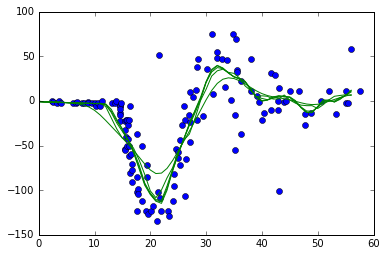

In [112]:
showPoints(points, 'b', 'o')
for kernel in kernels:
    curKernel = kernel
#     optH = getOptimalH()
#     LOWESS() 
#     print(delta)
    curP = []
    for x in range(0, maxi):
        curP.append([x, getY(x, optH)])
    print("kernel = ", kernelStr[curKernel], "; mean squared error = ", mean_squared_error([yi for [xi, yi] in points], [getY(xi, optH) for [xi, yi] in points]))
    showPoints(curP, 'g', '-')
show()

In [9]:
# k Nearest Neighbors algorithm used for classification
def kNN(k, metrics, train, test):
    k = min(k, len(train))
    result = []
    for point in test:
        distances = [[int(tpoint[2]), metrics(point[:2], tpoint[:2])] for tpoint in train]
        distances.sort(key=lambda p:p[1])
        #nlargest
        count0 = 0
        count1 = 1
        for i in range(k):
            if (distances[i][0] == 0):
                count0 = count0 + 1
            else:
                count1 = count1 + 1
        prediction = 1
        if (count0 > count1):
            prediction = 0
        result.append([point[0], point[1], int(point[2]), prediction])
    return result

In [10]:
# k-fold cross-validation
def training(data, k, metrics, kNN_value):
    kf = KFold(len(data), n_folds=k, shuffle=True)
    averageAccuracy = 0
    for train_index, test_index in kf:
        train = data.loc[train_index].as_matrix()
        test = data.loc[test_index].as_matrix()
        result = kNN(kNN_value, metrics, train, test)
        #f1 measure =  2 * (precision * recall) / (precision + recall)
        f1 = f1_score([row[2] for row in test], [row[3] for row in result]) 
        averageAccuracy += f1
    averageAccuracy /= k
    return averageAccuracy

In [11]:
data = getData()
result = pd.DataFrame(columns=['kNN', 'folds', 'metric', 'transformation', 'accuracy'])
transformations = [lambda x: x]#, lambda x: x ** 2, lambda x: x ** 0.5]
metrics = [cityblock, euclidean, cityblock, cosine, correlation]

#find the best value of k
for k in range(1, 20, 2): #len(train) // 2):
    for fold in [10]:
        for metric in metrics:
            for transform in transformations:
                curData = data[['x', 'y']].applymap(transform).join(data['class'])
                accuracy = training(curData, fold, metric, k)
                cur = pd.DataFrame([[k, fold, str(metric).split(' ')[1], 'x->x', accuracy]], columns=['kNN', 'folds', 'metric', 'transformation', 'accuracy'])
                result = result.append(cur, ignore_index=True)
display(result)
showPoints(result['kNN'], result['accuracy'], 'b', '-')

D:\Users\Daria\Documents\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1076: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


,kNN,folds,metric,transformation,accuracy
0,1.0,10.0,cityblock,x->x,0.650485
1,1.0,10.0,euclidean,x->x,0.630645
2,1.0,10.0,cityblock,x->x,0.653553
3,1.0,10.0,cosine,x->x,0.650165
4,1.0,10.0,correlation,x->x,0.649796
5,3.0,10.0,cityblock,x->x,0.694111
6,3.0,10.0,euclidean,x->x,0.693461
7,3.0,10.0,cityblock,x->x,0.675369
8,3.0,10.0,cosine,x->x,0.591074
9,3.0,10.0,correlation,x->x,0.652969


In [77]:
def showPoints(ticks, color, style):    
    x_ticks = [xi for [xi, yi] in ticks]
    y_ticks = [yi for [xi, yi] in ticks]
    plt.plot(x_ticks, y_ticks, color + style)
def show():
    plt.show()

In [8]:
data0 = train[train['class'] == 0]
    data0.append(test[(test['class'] == test['prediction']) & (test['class'] == 0)])
    data1 = train[train['class'] == 1]
    data1.append(test[(test['class'] == test['prediction']) & (test['class'] == 1)])
    data2 = test[test['class'] != test['prediction']]

IndentationError: unexpected indent (<ipython-input-8-9c2a31f42fc7>, line 2)